<a href="https://colab.research.google.com/github/SkyTong/DS440/blob/main/LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU

#np.set_printoptions(threshold=np.inf)

# Load the dataset

In [3]:
org_df = pd.read_csv('/content/processed_daily_data.csv',index_col=0)

In [4]:
org_df

,Unnamed: 0,Date,SP500,DOW30,EuroStoxx50,NASDAQ,CrudeOil,SSE,Gold,VIX,...,transaction_count,transaction_count_all_time,large_transaction_count,average_transaction_value,block_height,hashrate,difficulty,block_time,block_size,current_supply
7,7.0,2022-02-07,4483.870117,35091.128906,4120.560059,14015.669922,91.320000,3429.580078,1820.599976,22.860001,...,262034,708920351,22948,18.010471,722252,1.807953e+08,2.669053e+13,634.059259,1220094,18951581
8,8.0,2022-02-08,4521.540039,35462.781250,4129.250000,14194.450195,89.360001,3452.629883,1826.599976,21.440001,...,276850,709197201,23752,43.189954,722406,2.046145e+08,2.669053e+13,560.248366,1269141,18952606
9,9.0,2022-02-09,4587.180176,35768.058594,4204.089844,14490.370117,89.660004,3479.949951,1835.199951,19.959999,...,265804,709463005,21082,20.272357,722546,1.854157e+08,2.669053e+13,618.258993,1412872,18953425
10,10.0,2022-02-10,4504.080078,35241.589844,4197.069824,14185.639648,89.879997,3485.909912,1836.199951,23.910000,...,260813,709723818,21476,20.544074,722693,1.945608e+08,2.669053e+13,589.198630,1389048,18954337
11,11.0,2022-02-11,4418.640137,34738.058594,4155.229980,13791.150391,93.099998,3462.949951,1840.800049,27.360001,...,258595,709982413,20452,15.155736,722835,1.912526e+08,2.669053e+13,599.390071,1526755,18955312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,745.0,2024-02-15,5029.729980,38773.121094,4743.169922,15906.169922,78.029999,2865.903076,2002.099976,14.010000,...,303306,965991635,24170,3.222092,830643,6.060194e+08,7.756333e+13,549.705128,2080268,19629025
746,746.0,2024-02-16,5005.569824,38627.988281,4765.649902,15775.650391,79.190002,2865.903076,2011.500000,14.240000,...,312782,966304417,21666,2.991963,830777,5.467598e+08,8.172530e+13,641.977444,1807967,19629862
747,747.0,2024-02-17,5005.569824,38627.988281,4765.649902,15775.650391,79.190002,2865.903076,2011.500000,14.240000,...,327713,966632130,16967,1.708139,830927,6.086717e+08,8.172530e+13,576.677852,1848949,19630800
748,748.0,2024-02-18,5005.569824,38627.988281,4765.649902,15775.650391,79.190002,2865.903076,2011.500000,14.240000,...,343417,966975547,15213,1.676919,831048,4.904280e+08,8.172530e+13,715.716667,1848168,19631556


In [5]:
# Assuming your DataFrame is called org_df

# Remove the first column
org_df = org_df.drop(org_df.columns[0], axis=1)

# Now org_df will have the first column removed
org_df

,Date,SP500,DOW30,EuroStoxx50,NASDAQ,CrudeOil,SSE,Gold,VIX,Nikkei225,...,transaction_count,transaction_count_all_time,large_transaction_count,average_transaction_value,block_height,hashrate,difficulty,block_time,block_size,current_supply
7,2022-02-07,4483.870117,35091.128906,4120.560059,14015.669922,91.320000,3429.580078,1820.599976,22.860001,27248.869141,...,262034,708920351,22948,18.010471,722252,1.807953e+08,2.669053e+13,634.059259,1220094,18951581
8,2022-02-08,4521.540039,35462.781250,4129.250000,14194.450195,89.360001,3452.629883,1826.599976,21.440001,27284.519531,...,276850,709197201,23752,43.189954,722406,2.046145e+08,2.669053e+13,560.248366,1269141,18952606
9,2022-02-09,4587.180176,35768.058594,4204.089844,14490.370117,89.660004,3479.949951,1835.199951,19.959999,27579.869141,...,265804,709463005,21082,20.272357,722546,1.854157e+08,2.669053e+13,618.258993,1412872,18953425
10,2022-02-10,4504.080078,35241.589844,4197.069824,14185.639648,89.879997,3485.909912,1836.199951,23.910000,27696.080078,...,260813,709723818,21476,20.544074,722693,1.945608e+08,2.669053e+13,589.198630,1389048,18954337
11,2022-02-11,4418.640137,34738.058594,4155.229980,13791.150391,93.099998,3462.949951,1840.800049,27.360001,27696.080078,...,258595,709982413,20452,15.155736,722835,1.912526e+08,2.669053e+13,599.390071,1526755,18955312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2024-02-15,5029.729980,38773.121094,4743.169922,15906.169922,78.029999,2865.903076,2002.099976,14.010000,38157.941406,...,303306,965991635,24170,3.222092,830643,6.060194e+08,7.756333e+13,549.705128,2080268,19629025
746,2024-02-16,5005.569824,38627.988281,4765.649902,15775.650391,79.190002,2865.903076,2011.500000,14.240000,38487.238281,...,312782,966304417,21666,2.991963,830777,5.467598e+08,8.172530e+13,641.977444,1807967,19629862
747,2024-02-17,5005.569824,38627.988281,4765.649902,15775.650391,79.190002,2865.903076,2011.500000,14.240000,38487.238281,...,327713,966632130,16967,1.708139,830927,6.086717e+08,8.172530e+13,576.677852,1848949,19630800
748,2024-02-18,5005.569824,38627.988281,4765.649902,15775.650391,79.190002,2865.903076,2011.500000,14.240000,38487.238281,...,343417,966975547,15213,1.676919,831048,4.904280e+08,8.172530e+13,715.716667,1848168,19631556


In [6]:
org_df.columns

Index(['Date', 'SP500', 'DOW30', 'EuroStoxx50', 'NASDAQ', 'CrudeOil', 'SSE',
       'Gold', 'VIX', 'Nikkei225', 'FTSE100', 'EURUSD', 'CNYUSD', 'GBPUSD',
       'JPYUSD', 'CHFUSD', 'BTC', 'zero_balance_addresses_all_time',
       'unique_addresses_all_time', 'new_addresses', 'active_addresses',
       'transaction_count', 'transaction_count_all_time',
       'large_transaction_count', 'average_transaction_value', 'block_height',
       'hashrate', 'difficulty', 'block_time', 'block_size', 'current_supply'],
      dtype='object')

# Features engineering

In [7]:
org_df

,Date,SP500,DOW30,EuroStoxx50,NASDAQ,CrudeOil,SSE,Gold,VIX,Nikkei225,...,transaction_count,transaction_count_all_time,large_transaction_count,average_transaction_value,block_height,hashrate,difficulty,block_time,block_size,current_supply
7,2022-02-07,4483.870117,35091.128906,4120.560059,14015.669922,91.320000,3429.580078,1820.599976,22.860001,27248.869141,...,262034,708920351,22948,18.010471,722252,1.807953e+08,2.669053e+13,634.059259,1220094,18951581
8,2022-02-08,4521.540039,35462.781250,4129.250000,14194.450195,89.360001,3452.629883,1826.599976,21.440001,27284.519531,...,276850,709197201,23752,43.189954,722406,2.046145e+08,2.669053e+13,560.248366,1269141,18952606
9,2022-02-09,4587.180176,35768.058594,4204.089844,14490.370117,89.660004,3479.949951,1835.199951,19.959999,27579.869141,...,265804,709463005,21082,20.272357,722546,1.854157e+08,2.669053e+13,618.258993,1412872,18953425
10,2022-02-10,4504.080078,35241.589844,4197.069824,14185.639648,89.879997,3485.909912,1836.199951,23.910000,27696.080078,...,260813,709723818,21476,20.544074,722693,1.945608e+08,2.669053e+13,589.198630,1389048,18954337
11,2022-02-11,4418.640137,34738.058594,4155.229980,13791.150391,93.099998,3462.949951,1840.800049,27.360001,27696.080078,...,258595,709982413,20452,15.155736,722835,1.912526e+08,2.669053e+13,599.390071,1526755,18955312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2024-02-15,5029.729980,38773.121094,4743.169922,15906.169922,78.029999,2865.903076,2002.099976,14.010000,38157.941406,...,303306,965991635,24170,3.222092,830643,6.060194e+08,7.756333e+13,549.705128,2080268,19629025
746,2024-02-16,5005.569824,38627.988281,4765.649902,15775.650391,79.190002,2865.903076,2011.500000,14.240000,38487.238281,...,312782,966304417,21666,2.991963,830777,5.467598e+08,8.172530e+13,641.977444,1807967,19629862
747,2024-02-17,5005.569824,38627.988281,4765.649902,15775.650391,79.190002,2865.903076,2011.500000,14.240000,38487.238281,...,327713,966632130,16967,1.708139,830927,6.086717e+08,8.172530e+13,576.677852,1848949,19630800
748,2024-02-18,5005.569824,38627.988281,4765.649902,15775.650391,79.190002,2865.903076,2011.500000,14.240000,38487.238281,...,343417,966975547,15213,1.676919,831048,4.904280e+08,8.172530e+13,715.716667,1848168,19631556


In [8]:
import pandas as pd

# Assuming your DataFrame is called org_df

# Convert 'Datetime' column to datetime data type
org_df['Date'] = pd.to_datetime(org_df['Date'])

# Set 'Datetime' column as the index
org_df.set_index('Date', inplace=True)

# Now 'Datetime' column should be the index of the DataFrame
# Check the data type of the index
print("Data type of elements in the index:", org_df.index.dtype)

# Check the data types of all columns again
print("\nData types of all columns:")
print(org_df.dtypes)


Data type of elements in the index: datetime64[ns]

Data types of all columns:
SP500                              float64
DOW30                              float64
EuroStoxx50                        float64
NASDAQ                             float64
CrudeOil                           float64
SSE                                float64
Gold                               float64
VIX                                float64
Nikkei225                          float64
FTSE100                            float64
EURUSD                             float64
CNYUSD                             float64
GBPUSD                             float64
JPYUSD                             float64
CHFUSD                             float64
BTC                                float64
zero_balance_addresses_all_time      int64
unique_addresses_all_time            int64
new_addresses                        int64
active_addresses                     int64
transaction_count                    int64
transaction_count_

# Dataset scalling

In [9]:
dataset = org_df.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
#print('dataset.shape', dataset.shape)
num_of_features = len(org_df.columns)
print('Number of features', num_of_features)

Number of features 30


# Configuration

In [71]:
expr_name = 'expr_16'
look_back = 100 # 60 days, as each entry is for 1 hour
lstm_layers = 64
epochs=5
batch_size=64

# spliting datasets into train and test

In [72]:
train_size_percent = 0.80
pred_col = org_df.columns.get_loc('BTC')

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back, pred_col])
  return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look_back ', look_back)

Training dataset length  594
Testing dataset length  149
look_back  100


In [73]:
trainY

array([0.35556638, 0.39939195, 0.3687759 , 0.37514013, 0.39965004,
       0.36597627, 0.38128096, 0.37871796, 0.37060374, 0.35301787,
       0.358168  , 0.37551767, 0.4382136 , 0.44002593, 0.38522607,
       0.4036026 , 0.38262278, 0.38615626, 0.38818383, 0.42843378,
       0.42251748, 0.39664322, 0.3938291 , 0.365561  , 0.34568375,
       0.30174547, 0.18420583, 0.17649144, 0.18655515, 0.12631285,
       0.12878257, 0.08881217, 0.13103122, 0.13230318, 0.13535655,
       0.1154635 , 0.14567411, 0.14968204, 0.15712386, 0.14406353,
       0.13604063, 0.12353563, 0.11868006, 0.10990161, 0.09573287,
       0.09498745, 0.09649467, 0.1221782 , 0.12104696, 0.13089305,
       0.1608423 , 0.1634137 , 0.15959466, 0.13947642, 0.11501062,
       0.09723252, 0.1216507 , 0.13148892, 0.13881326, 0.14854544,
       0.13724661, 0.18415916, 0.20900577, 0.20467007, 0.20282519,
       0.19046295, 0.18360347, 0.18755382, 0.15325737, 0.14990467,
       0.19638968, 0.22150004, 0.22042084, 0.21634012, 0.20756

# Build the model and train

In [74]:
# create and fit the LSTM network

model = Sequential()
model.add(LSTM(lstm_layers, return_sequences=True, input_shape=(look_back,num_of_features)))
model.add(GRU(lstm_layers))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history= model.fit(trainX, trainY,validation_split=0.30, epochs=epochs, batch_size=batch_size,shuffle=False)

Epoch 1/5
6/6 [==============================] - 6s 300ms/step - loss: 0.0436 - val_loss: 0.1109
Epoch 2/5
6/6 [==============================] - 1s 123ms/step - loss: 0.0161 - val_loss: 0.0372
Epoch 3/5
6/6 [==============================] - 1s 139ms/step - loss: 0.0086 - val_loss: 0.0527
Epoch 4/5
6/6 [==============================] - 1s 127ms/step - loss: 0.0105 - val_loss: 0.0187
Epoch 5/5
6/6 [==============================] - 1s 125ms/step - loss: 0.0067 - val_loss: 0.0316


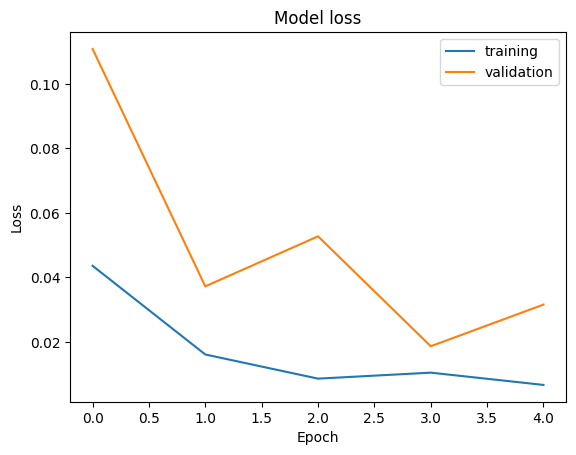

In [75]:
# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [76]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col]

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

2/2 [==============================] - 0s 21ms/step


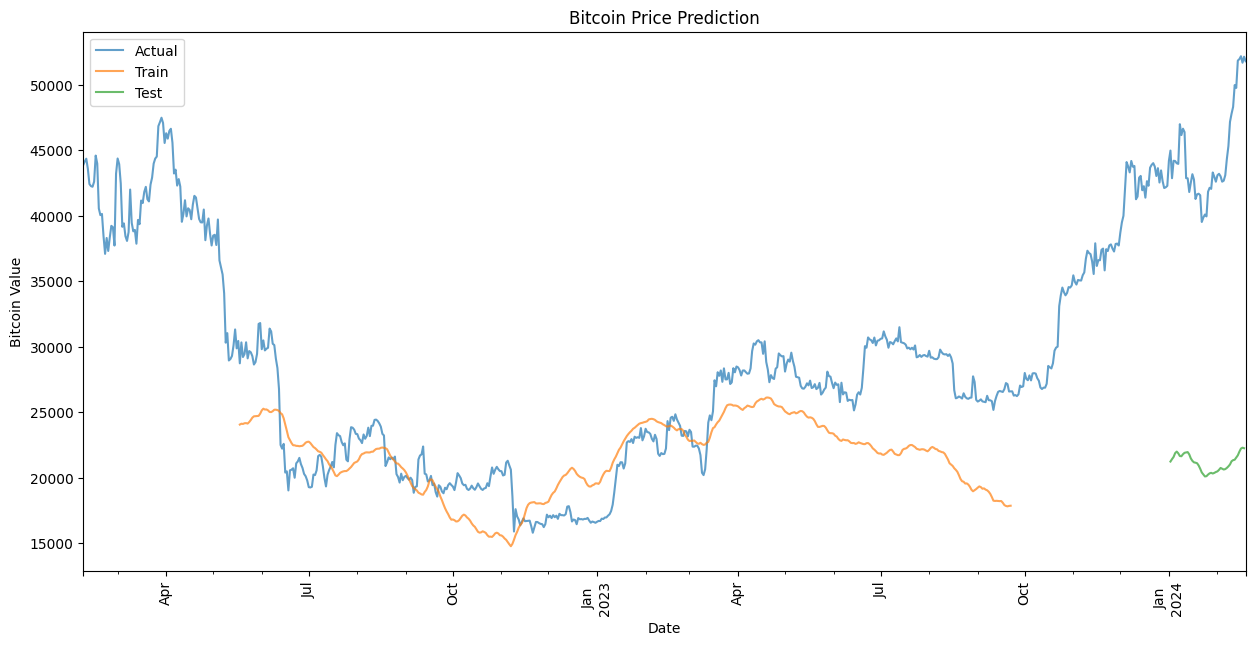

In [77]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

# contruct pandas dataframe for plotting
time_df = pd.DataFrame(org_df.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
time_df2.set_index('Date',inplace=True)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Bitcoin Value')
plt.title('Bitcoin Price Prediction')
plt.savefig(expr_name + '.png',bbox_inches = "tight")

In [78]:
print('-' * 50)
print('Experiment name:', expr_name)

print('-' * 50)
print('look_back days:', look_back/24)
print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(org_df.columns))


print('-' * 50)
print('Train Score: %.2f RMSE' % (trainScore_RMSE))
print('Test Score: %.2f RMSE' % (testScore_RMSE))

print('-' * 50)
print('Train Score: %.2f MAE' % (trainScore_MAE))
print('Test Score: %.2f MAE' % (testScore_MAE))

print('-' * 50)
print('Model summary:')
model.summary()

--------------------------------------------------
Experiment name: expr_16
--------------------------------------------------
look_back days: 4.166666666666667
lstm_layers: 64
epochs: 5
batch_size: 64
dataset features ['SP500', 'DOW30', 'EuroStoxx50', 'NASDAQ', 'CrudeOil', 'SSE', 'Gold', 'VIX', 'Nikkei225', 'FTSE100', 'EURUSD', 'CNYUSD', 'GBPUSD', 'JPYUSD', 'CHFUSD', 'BTC', 'zero_balance_addresses_all_time', 'unique_addresses_all_time', 'new_addresses', 'active_addresses', 'transaction_count', 'transaction_count_all_time', 'large_transaction_count', 'average_transaction_value', 'block_height', 'hashrate', 'difficulty', 'block_time', 'block_size', 'current_supply']
--------------------------------------------------
Train Score: 4218.59 RMSE
Test Score: 23553.82 RMSE
--------------------------------------------------
Train Score: 3417.23 MAE
Test Score: 23353.52 MAE
--------------------------------------------------
Model summary:
Model: "sequential_7"
__________________________________